<a href="https://colab.research.google.com/github/eliorav/1000G-downloader/blob/master/sentiment_analysis_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 890kB 6.8MB/s 
     |████████████████████████████████| 3.8MB 12.9MB/s 
     |████████████████████████████████| 1.0MB 28.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=bea1f0f44fcbc8378299ce12d446107fec4a2212ebb217dea7cf5262ccd1388d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import torch
import torch.nn as nn

# fastai
from fastai.text import *
from fastai.metrics import *

# transformers
from transformers import AutoModelWithLMHead, AutoTokenizer, PreTrainedTokenizer, AutoModel, AutoConfig

In [0]:
use_fp16 = True
bs = 8
num_labels = 2

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

In [4]:
transformer_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

In [5]:
path = untar_data(URLs.AMAZON_REVIEWS)
path.ls()

[PosixPath('/root/.fastai/data/amazon_review_full_csv/test.csv'),
 PosixPath('/root/.fastai/data/amazon_review_full_csv/train.csv'),
 PosixPath('/root/.fastai/data/amazon_review_full_csv/readme.txt')]

In [0]:
train_df = pd.read_csv(path/'train.csv', names=['label', 'title', 'text'])
train_df = train_df[train_df['label'] != 3][:100000]
train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
neg_rows = train_df['label'] < 3
pos_rows = train_df['label'] > 3
train_df.loc[pos_rows, 'label'] = 'pos'
train_df.loc[neg_rows, 'label'] = 'neg'
train_clas_df = train_df.drop(columns=['title'])
train_clas_df.to_csv(path/'train_clas.csv')

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [0]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer, model_type=model_type)
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [0]:
class TransformersTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

In [0]:
def get_transformers_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [TransformersTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [0]:
transformer_vocab =  TransformersVocab(tokenizer=transformer_tokenizer)
transformer_processor = get_transformers_processor(tokenizer=fastai_tokenizer, vocab=transformer_vocab)

In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [14]:
data_clas = (TextList.from_csv(path, 'train_clas.csv', cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1)
             .label_from_df(cols=1)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

data_clas.save('RoBERTa_data_clas.pkl')

In [0]:
data_clas = load_data(path, 'RoBERTa_data_clas.pkl', bs=bs, pad_first=pad_first, pad_idx=pad_idx)

In [0]:
model_config = AutoConfig.from_pretrained(pretrained_model_name)
model_config.num_labels = num_labels
model_config.use_bfloat16 = use_fp16

In [17]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name, config = model_config)

In [0]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self,transformer_model, num_labels=2):
        super(SentimentAnalysisModel,self).__init__()
        self.num_labels = num_labels
        self.transformer_model = transformer_model
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.transformer_model(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)

        return logits

In [0]:
model = SentimentAnalysisModel(transformer_model, num_labels)

In [0]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

In [0]:
learner = Learner(data_clas, model, opt_func = CustomAdamW, metrics=[accuracy], callback_fns=ShowGraph)

In [0]:
if use_fp16: learner = learner.to_fp16()

In [0]:
list_layers = [learner.model.transformer_model.embeddings,
              learner.model.transformer_model.encoder.layer[0],
              learner.model.transformer_model.encoder.layer[1],
              learner.model.transformer_model.encoder.layer[2],
              learner.model.transformer_model.encoder.layer[3],
              learner.model.transformer_model.encoder.layer[4],
              learner.model.transformer_model.encoder.layer[5],
              learner.model.transformer_model.encoder.layer[6],
              learner.model.transformer_model.encoder.layer[7],
              learner.model.transformer_model.encoder.layer[8],
              learner.model.transformer_model.encoder.layer[9],
              learner.model.transformer_model.encoder.layer[10],
              learner.model.transformer_model.encoder.layer[11],
              learner.model.transformer_model.pooler]

In [0]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)

In [0]:
learner.freeze_to(-1)

In [26]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-07


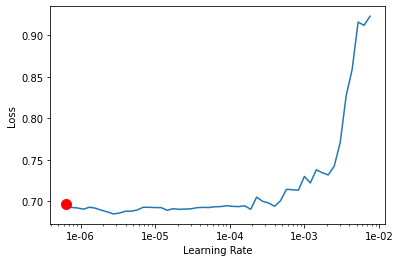

In [27]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.320465,0.278306,0.885200,07:48


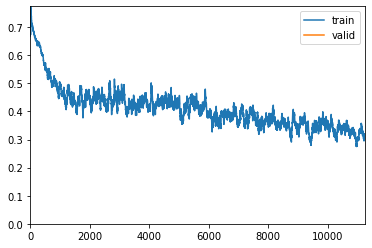

In [28]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [0]:
learner.save('RoBERTa_first_cycle')

In [0]:
learner.freeze_to(-2)

In [0]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,time
0,0.163339,0.196712,0.924500,09:37


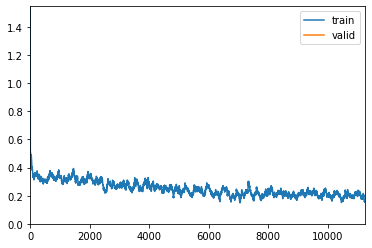

In [32]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('RoBERTa_second_cycle')

In [0]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.146413,0.172722,0.934300,11:35


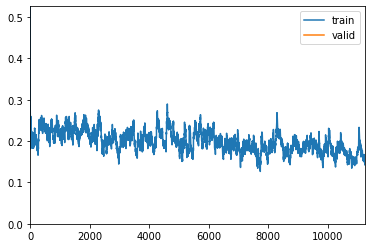

In [35]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('RoBERTa_third_cycle')

In [0]:
learner.load('RoBERTa_third_cycle');

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.185294,0.172620,0.934100,31:30
1,0.084136,0.140478,0.950900,31:43


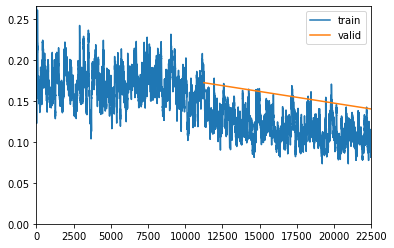

In [39]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('RoBERTa_unfreeze_cycle')